<a href="https://colab.research.google.com/github/parsa-abbasi/Sentiment-Analysis/blob/master/Binary-Classification/ML_Algorithms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Requirements

## Install required libraries

In [4]:
!pip install hazm
!pip install stopwords_guilannlp
!pip install matplotlib==3.1.0

## Import Libraries

In [0]:
# General
import numpy as np
import pandas as pd
import codecs
from google.colab import files
# sklearn
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC, SVC
from sklearn.pipeline import Pipeline
# Preprocessing
from stopwords_guilannlp import stopwords_output
from hazm import *
# Visualization
%matplotlib inline
import matplotlib.pyplot as plt

# Upload dataset files

Upload dataset files to colab environment

You can access to dataset files through following links:

(x_train, x_test, y_train, y_test)
- [Original dataset](https://github.com/parsa-abbasi/Sentiment-Analysis/tree/master/Dataset/Original)
- [Balanced with extra data](https://github.com/parsa-abbasi/Sentiment-Analysis/tree/master/Dataset/BalancedWithExtra)
- [Data Augmentation - Full Translate](https://github.com/parsa-abbasi/Sentiment-Analysis/tree/master/Dataset/FullTranslate)
- [Data Augmentation - Synonyms](https://github.com/parsa-abbasi/Sentiment-Analysis/tree/master/Dataset/Synonyms)

In [6]:
from google.colab import files
uploaded = files.upload()

Saving x_test.csv to x_test.csv
Saving x_train.csv to x_train.csv
Saving y_test.csv to y_test.csv
Saving y_train.csv to y_train.csv



# Import & Analyze Dataset

In [0]:
x_train = pd.read_csv('x_train.csv', sep='\t', index_col=None, header=None, encoding="utf-8")[1]
x_test = pd.read_csv('x_test.csv', sep='\t', index_col=None, header=None, encoding="utf-8")[1]
y_train = pd.read_csv('y_train.csv', sep='\t', index_col=None, header=None)[1]
y_test = pd.read_csv('y_test.csv', sep='\t', index_col=None, header=None)[1]

In [0]:
# The dataset csv files created using old version of Pandas
# so we need to do some additional preparation
x_train = x_train[1:]
x_train = x_train.reset_index(drop=True)
x_test = x_test[1:]
x_test = x_test.reset_index(drop=True)
y_train = y_train[1:]
y_train = y_train.reset_index(drop=True)
y_test = y_test[1:]
y_test = y_test.reset_index(drop=True)

In [9]:
print('Number of training sentence: ', x_train.shape)
print('Number of training label: ', y_train.shape)
print('Number of testing sentence: ', x_test.shape)
print('Number of testing label: ', y_test.shape)

Number of training sentence:  (7023,)
Number of training label:  (7023,)
Number of testing sentence:  (1854,)
Number of testing label:  (1854,)


Remove *neutral* sentences from the dataset

In [0]:
binary_y_train = []
binary_y_test = []
binary_x_train = []
binary_x_test = []
for i, y in enumerate(y_train):
  if y != 0:
    if y > 0:
      binary_y_train.append(1)
      binary_x_train.append(x_train[i])
    else:
      binary_y_train.append(0)
      binary_x_train.append(x_train[i])
      
for i, y in enumerate(y_test):
  if y != 0:
    if y > 0:
      binary_y_test.append(1)
      binary_x_test.append(x_test[i])
    else:
      binary_y_test.append(0)
      binary_x_test.append(x_test[i])


In [0]:
# Convert dataframes to numpy arrays
x_train = np.asarray(binary_x_train)
x_test = np.asarray(binary_x_test)
y_train = np.asarray(binary_y_train)
y_test = np.asarray(binary_y_test)

In [12]:
# See the data number of sentence in each category 
from collections import Counter
cnt = Counter(y_train)
cnt = dict(cnt)
print(cnt)

{1: 3928, 0: 1095}


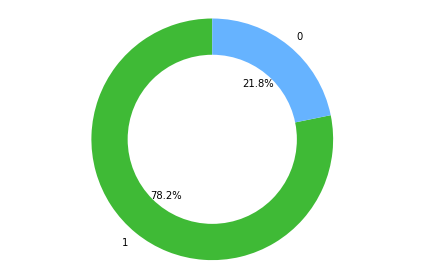

In [13]:
labels = list(cnt.keys())
sizes = list(cnt.values())
colors = ['#3fba36', '#66b3ff','#ffcc99','#ff9999', '#d44444']
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, colors=colors,
        autopct='%1.1f%%', startangle=90)
#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout()
# Decomment following line if you want to save the figure
# plt.savefig('balanced_with_extra.png')
plt.show()

In [0]:
# Decomment following line if you want to download dataset figure
# files.download('balanced_with_extra.png')

# Preprocess

In [0]:
# Customize preprocessing
puncs = ['،', '.', ',', ':', ';', '"']

# Hazm library
normalizer = Normalizer()
lemmatizer = Lemmatizer()

# Apply preprocessing to a document
def clean_doc(doc):
  # Normalize document
  doc = normalizer.normalize(doc)
  # Tokenize text
  tokenized = word_tokenize(doc)
  # Remove punctuation
  tokens = []
  for t in tokenized:
    temp = t
    for p in puncs:
      temp = temp.replace(p, '')
    if temp.isdigit():
      tokens.append('<DIGIT>')
    else:
      tokens.append(temp)
  # Remove stop words
  # tokens = [w for w in tokens if not w in stop_set]
  # Remove one length words
  tokens = [w for w in tokens if not len(w) <= 1]
  # Remove digits
  #tokens = [w for w in tokens if not w.isdigit()]
  # Lemmatize sentence words using Hazm Lemmatizer
  tokens = [lemmatizer.lemmatize(w) for w in tokens]
  # Merge tokens to a single string
  tokens = ' '.join(tokens)
  return tokens

In [0]:
# Apply preprocessing step to training data
train_docs = np.empty_like(x_train)
for index, document in enumerate(x_train):
  train_docs[index] = clean_doc(document)

In [0]:
# Applying preprocessing step to test data
test_docs = np.empty_like(x_test)
for index, document in enumerate(x_test):
  test_docs[index] = clean_doc(document)

# Machine Learning Algorithms

In [0]:
# Make stop word set
stop_set = stopwords_output("Persian", "set")


# When building the vocabulary ignore terms that have a document frequency strictly lower than
# the given threshold. This value is also called cut-off in the literature.
min_df = 1


# Tokenize function used in Vectorizer
def tokenize(text):
    return word_tokenize(text)

## Naive Bayes

In [19]:
# (Multinomial) Naive Bayes Model
naive_bayes = Pipeline([('vect', CountVectorizer(tokenizer=tokenize,
                                              analyzer='word', ngram_range=(1, 2), min_df=min_df, lowercase=False)),
                     ('tfidf', TfidfTransformer(sublinear_tf=True)),
                     ('clf', MultinomialNB())])
naive_bayes = naive_bayes.fit(x_train, y_train)
naive_score = naive_bayes.score(x_test, y_test)
print('Naive Bayes Model: ', naive_score)
predict_nb = naive_bayes.predict(x_test)

Naive Bayes Model:  0.828082808280828


## Support Vector Machine

In [20]:
# Linear Support Vector Machine Model
svm = Pipeline([('vect', CountVectorizer(tokenizer=tokenize,
                                                         analyzer='word', ngram_range=(1, 2),
                                                         min_df=min_df, lowercase=False)),
                                ('tfidf', TfidfTransformer(sublinear_tf=True)),
                                ('clf-svm', LinearSVC(loss='hinge', penalty='l2',
                                                      max_iter=5))])

svm = svm.fit(x_train, y_train)
linear_svc_score = svm.score(x_test, y_test)
print('Linear SVC Model: ', linear_svc_score)
predict_svm = svm.predict(x_test)

Linear SVC Model:  0.9135913591359136


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


## Stochastic Gradient Descent

In [21]:
# SGD (Stochastic Gradient Descent) Model
sgd = Pipeline([('vect', CountVectorizer(tokenizer=tokenize,
                                                  analyzer='word', ngram_range=(1, 2), min_df=min_df, lowercase=False)),
                         ('tfidf', TfidfTransformer(sublinear_tf=True)),
                         ('clf-svm', SGDClassifier(loss='hinge', penalty='l2',
                                                   alpha=1e-3, max_iter=5))])
sgd = sgd.fit(x_train, y_train)
sgd_score = sgd.score(x_test, y_test)
print('SGD Model: ', sgd_score)
predict_sgd = sgd.predict(x_test)

SGD Model:  0.8226822682268227


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


# Confusion Matrix

In [22]:
y_test_label = []
for counter in range(0, len(categorical_y_test)-1):
  label = np.argmax(categorical_y_test[:-1][counter])
  y_test_label.append(label)
y_test_label = np.array(y_test_label)

NameError: ignored

In [0]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    print(im)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

class_names = np.array([0, 1, 2, -2, -1])
np.set_printoptions(precision=2)

Confusion matrix, without normalization
[[  5 191]
 [  0 915]]
AxesImage(54,36;334.8x217.44)
Normalized confusion matrix
[[0.03 0.97]
 [0.   1.  ]]
AxesImage(54,36;334.8x217.44)


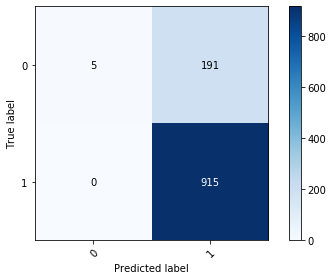

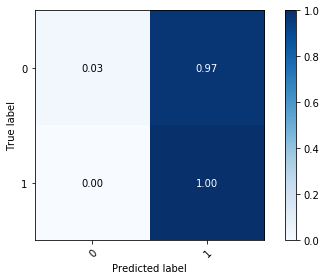

In [24]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, predict_nb, classes=class_names)
plt.savefig('cm-nb.png')
# Plot normalized confusion matrix
plot_confusion_matrix(y_test, predict_nb, classes=class_names, normalize=True)
plt.savefig('cm-nb-normalized.png')
plt.show()

In [0]:
# Decomment following line if you want to download confusion matrix figure
# files.download('cm-nb.png')
# files.download('cm-nb-normalized.png')

Confusion matrix, without normalization
[[129  67]
 [ 29 886]]
AxesImage(54,36;334.8x217.44)
Normalized confusion matrix
[[0.66 0.34]
 [0.03 0.97]]
AxesImage(54,36;334.8x217.44)


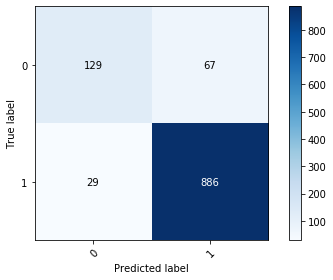

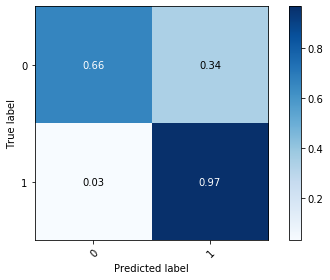

In [26]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, predict_svm, classes=class_names)
plt.savefig('cm-svm.png')
# Plot normalized confusion matrix
plot_confusion_matrix(y_test, predict_svm, classes=class_names, normalize=True)
plt.savefig('cm-svm-normalized.png')
plt.show()

In [0]:
# Decomment following line if you want to download confusion matrix figure
# files.download('cm-svm.png')
# files.download('cm-svm-normalized.png')

Confusion matrix, without normalization
[[  0 196]
 [  1 914]]
AxesImage(54,36;334.8x217.44)
Normalized confusion matrix
[[0. 1.]
 [0. 1.]]
AxesImage(54,36;334.8x217.44)


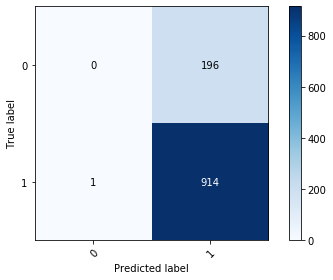

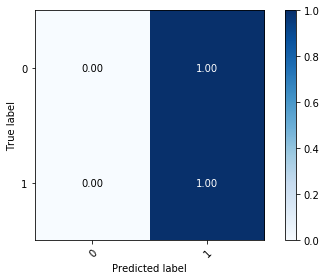

In [28]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, predict_sgd, classes=class_names)
plt.savefig('cm-sgd.png')
# Plot normalized confusion matrix
plot_confusion_matrix(y_test, predict_sgd, classes=class_names, normalize=True)
plt.savefig('cm-sgd-normalized.png')
plt.show()

In [0]:
# Decomment following line if you want to download confusion matrix figure
# files.download('cm-sgd.png')
# files.download('cm-sgd-normalized.png')